In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from hyperopt import hp, tpe, fmin, Trials
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder



In [40]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


In [41]:
# Load the dataset
df = pd.read_csv('WineQT.csv')

# Separate features and target variable
X, y = df.drop(columns = ['quality']), df.loc[:, 'quality']

# Function to preprocess the data
def preprocess_data(X, y):
    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        label_encoders[column] = LabelEncoder()
        X[column] = label_encoders[column].fit_transform(X[column])
    return X, y

# Function to split the data
def split_data(X, y, test_size=0.2, val_size=0.25):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    val_size_adjusted = val_size / (1 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, random_state=42)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



In [42]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1595


In [43]:
# Preprocess the data
X, y = preprocess_data(X, y)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

# Define the hyperparameter space
hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}

# Define the objective function for regression
def objective_function(hyperparameters):
    global iteration_n
    if iteration_n == 0:
        model = XGBRegressor()
    else:
        hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
        hyperparameters['n_estimators'] = int(hyperparameters['n_estimators'])
        hyperparameters['min_child_weight'] = int(hyperparameters['min_child_weight'])
        model = XGBRegressor(**hyperparameters)
    iteration_n += 1
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = mean_squared_error(y_val, y_predict)
    return score



In [44]:
# Initialize hyperopt trials and iteration counter
trials = Trials()
iteration_n = 0

# Run hyperparameter optimization
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
scores_round = np.array(trials.losses())



100%|██████████| 20/20 [01:12<00:00,  3.64s/trial, best loss: 0.24377762721281557]


In [45]:
scores_round

array([ 0.29347072, 13.87779987,  0.30833583, 22.28352975,  0.60893159,
        0.3668901 ,  0.29699521, 10.03502083,  0.26457725,  0.28406802,
        4.15884185,  0.27154282, 14.34294898,  0.25480853, 22.05881844,
        0.30416038,  0.24377763, 10.32595459,  7.64797795,  0.28382125])

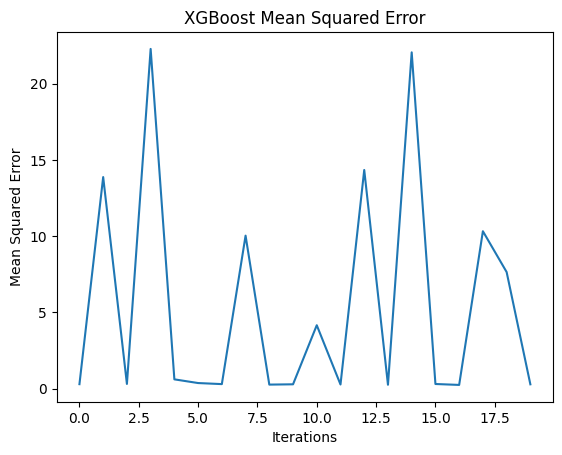

Best Hyperparameters: {'alpha': 0.04649878942131961, 'colsample_bylevel': 0.5692304745829406, 'colsample_bytree': 0.8880616383680686, 'gamma': 0.03341617016386546, 'lambda': 1.2694330064409378, 'learning_rate': 0.008119384168287579, 'max_depth': 11.0, 'min_child_weight': 2.0, 'n_estimators': 5400.0, 'subsample': 0.8001894591684181}
Best Trial: {'state': 2, 'tid': 16, 'spec': None, 'result': {'loss': 0.24377762721281557, 'status': 'ok'}, 'misc': {'tid': 16, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [16], 'colsample_bylevel': [16], 'colsample_bytree': [16], 'gamma': [16], 'lambda': [16], 'learning_rate': [16], 'max_depth': [16], 'min_child_weight': [16], 'n_estimators': [16], 'subsample': [16]}, 'vals': {'alpha': [0.04649878942131961], 'colsample_bylevel': [0.5692304745829406], 'colsample_bytree': [0.8880616383680686], 'gamma': [0.03341617016386546], 'lambda': [1.2694330064409378], 'learning_rate': [0.008119384168287579], 'max_depth': [11.0], 'mi

In [46]:
# Save the best hyperparameters
with open('best_wine_xgboost_params_regression.pkl', 'wb') as f:
    pickle.dump(best_hyperparameters, f)

# Plot the mean squared error over iterations
plt.plot(range(20), scores_round)
plt.title('XGBoost Mean Squared Error')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.show()

# Display the best hyperparameters and the best trial
print("Best Hyperparameters:", best_hyperparameters)
print("Best Trial:", trials.best_trial)
